# Animal Classification

## Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as du
from torch.utils.data import Dataset
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import cv2 
import numpy as np
from tqdm import tqdm

## Loading Dataset

In [2]:
# https://www.kaggle.com/datasets/vitalymakin/flower-from-shops-classification
# https://www.kaggle.com/datasets/virtualdvid/oregon-wildlife
def load_dataset(data_path, save_data_path, image_size, saved=False):
    '''
    data_path: directory containing where images of the same label are stored in the same subfolder
    save_data_path: location to store processed dataset
    saved: if True, load array from save_data_path. If false, dataset needs to be created from data_path
    '''
    if(saved):
        with open(save_data_path, 'rb') as f:
            dataset = np.load(f)
            labels = np.load(f)
            return dataset, labels
    start_path = os.getcwd()
    os.chdir(data_path)
    dataset = []
    labels = []
    label_idx = 0
    folder_list = os.listdir('./')
    for folder in tqdm(folder_list):  # each folder stores one label
        os.chdir(folder)
        file_list = os.listdir('./')
        for file in file_list:   # iterating through each folder and saving img along with its label
            img = cv2.imread(file)
            if(img is not None): # save img if reading image is successful
                dataset.append(cv2.resize(img, image_size))
                labels.append(label_idx)
        label_idx += 1
        os.chdir("./..")
    os.chdir(start_path)
    dataset = np.array(dataset, dtype=np.uint8)
    labels = np.array(labels, dtype=np.uint8)
    with open(save_data_path, 'wb') as f:  # saving dataset because it takes a long time to generate it every time
        np.save(f, dataset, allow_pickle=True)
        np.save(f, labels, allow_pickle=True)
        return dataset, labels

In [3]:
def split_dataset(dataset, labels, split=np.array([.8,.1,.1])):
    '''
    dataset: features
    labels: labels
    split: train/val/test 
    returns a three tuples of (dataset, labels) for train/val/test splits
    '''
    assert(np.sum(split) == 1)
    split = np.cumsum(split)
    permutation = np.random.permutation(labels.shape[0])
    dataset = dataset[permutation]
    labels = labels[permutation]
    dataset = np.einsum("bijc->bcij", dataset)
    train_data = (dataset[:int(dataset.shape[0]*split[0])], labels[:int(dataset.shape[0]*split[0])])
    valid_data = (dataset[int(dataset.shape[0]*split[1]):int(dataset.shape[0]*split[2])], labels[int(dataset.shape[0]*split[1]):int(dataset.shape[0]*split[2])])
    test_data = (dataset[int(dataset.shape[0]*split[1]):], labels[int(dataset.shape[0]*split[1]):])
    return train_data, valid_data, test_data


In [4]:
dataset, labels = load_dataset("./Datasets/oregon_wildlife", "./Datasets/wildlife_dataset.npy", (96, 96), True)
train_data, valid_data, test_data = split_dataset(dataset, labels)
print(f"Size of Training Set {train_data[0].shape[0]}")
print(f"Size of Validation Set {valid_data[0].shape[0]}")
print(f"Size of Testing Set {test_data[0].shape[0]}")

Size of Training Set 11160
Size of Validation Set 1396
Size of Testing Set 1396


## Visualizing Dataset

## Dataset Class

In [5]:
class Image_Dataset(Dataset):
    def __init__(self, data):
        '''
        data: tuple of (features, labels)
        '''
        super(Image_Dataset, self).__init__()
        self.images = torch.tensor(data[0], dtype=torch.float)
        self.images[:,0] = (self.images[:,0]-torch.mean(self.images[:,0])) / torch.std(self.images[:,0])
        self.images[:,1] = (self.images[:,1]-torch.mean(self.images[:,1])) / torch.std(self.images[:,1])
        self.images[:,2] = (self.images[:,2]-torch.mean(self.images[:,2])) / torch.std(self.images[:,2])
        self.labels = torch.tensor(data[1], dtype=torch.long)

        

    def __len__(self):
        '''return len of dataset'''
        return self.images.shape[0]
        
    def __getitem__(self, idx):
        '''return sequence, future sequence'''
        return self.images[idx], self.labels[idx]

In [6]:
class CNN(nn.Module):
    def __init__(self, in_channels, num_classes, pretrain = False):
        '''
        in_dim: input layer dim
        hidden_layers: hidden layers in lstm
        '''
        super(CNN, self).__init__()
        self.flatten = nn.Flatten()
        if(pretrain == True):
            mobilenetv2 = models.mobilenet_v2(pretrained=True)
            self.backbone = nn.Sequential(*list(mobilenetv2.children())[:-1])
            for param in self.backbone.parameters():
                param.requires_grad = False
            self.linear = nn.Sequential(
                            nn.Linear(11520, 6000),
                            nn.ReLU(),
                            nn.Linear(6000, 1000),
                            nn.ReLU(),
                            nn.Linear(1000, 500),
                            nn.ReLU(),
                            nn.Linear(500, num_classes),
                        )
        else:
            cnn_stack = []
            cnn_stack.append(nn.Conv2d(3, 64, (5,5)))
            cnn_stack.append(nn.ReLU())
            cnn_stack.append(nn.Conv2d(64, 64, (5,5)))
            cnn_stack.append(nn.ReLU())
            cnn_stack.append(nn.MaxPool2d((3,3)))
            cnn_stack.append(nn.Conv2d(64, 128, (4,4)))
            cnn_stack.append(nn.ReLU())
            cnn_stack.append(nn.Conv2d(128, 128, (3,3)))
            cnn_stack.append(nn.ReLU())
            cnn_stack.append(nn.Conv2d(128, 128, (3,3)))
            cnn_stack.append(nn.ReLU())
            cnn_stack.append(nn.MaxPool2d((3,3)))
            self.backbone = nn.Sequential(*cnn_stack)
            self.linear = nn.Sequential(
                            nn.Linear(6272, 1000),
                            nn.ReLU(),
                            nn.Linear(1000, 500),
                            nn.ReLU(),
                            nn.Linear(500, num_classes),
                        )
    def forward(self, x):
        x = self.flatten(self.backbone(x))
        x = self.linear(x)

        return x

In [7]:
device = f'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f"using device: {device}")

# hyper parameters
batch_size = 128
learning_rate = 1e-3
epochs = 10
in_channels = 3
num_classes = 20

#initializing model and optimizer
model = CNN(in_channels, num_classes, True)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loader = du.DataLoader(dataset=Image_Dataset(train_data),
                             batch_size=batch_size,
                             shuffle=True)
valid_loader = du.DataLoader(dataset=Image_Dataset(valid_data),
                             batch_size=batch_size,
                             shuffle=True)
test_loader = du.DataLoader(dataset=Image_Dataset(test_data),
                             batch_size=batch_size,
                             shuffle=True)

# sending model to device
model.to(device)
# set model to training mode
model.train()

using device: cuda:0


CNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (backbone): Sequential(
    (0): Sequential(
      (0): ConvNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): ConvNormActivation(
            (0): Conv

## Training Transfer Learning Model

In [8]:
train_loss_list = []
valid_loss_list = []
valid_acc_list = []
# iterating through all epochs
for epoch in range(1, epochs+ 1):    
    # training step
    train_loss = 0.
    model.train()

    # iterating through entire dataset in batches
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):

        # sending batch over to device
        data, target = data.to(device), target.to(device)

        # zeroing out previous gradients
        optimizer.zero_grad()

        # getting predictions from model
        output = model(data)

        # claculating cross entropyloss
        loss = F.cross_entropy(output, target)

        train_loss += loss.item()

        # Gradient Descent and Backprop
        loss.backward()
        optimizer.step()
    
    # validation step
    valid_loss = 0

    # turning off gradient for validation step
    model.eval()
    valid_loss = 0
    valid_acc = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(tqdm(valid_loader)):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = F.cross_entropy(output, target)
            valid_loss += loss.item()
            output = F.softmax(output, dim=-1)
            pred = torch.argmax(output, dim=-1)
            correct = torch.sum(pred == target, dtype=torch.float)
            valid_acc += correct
    
    train_loss /= len(train_loader.dataset)
    valid_loss /= len(valid_loader.dataset)
    valid_acc /= len(valid_loader.dataset)
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    valid_acc_list.append(valid_acc.detach().cpu().numpy())

    # printing loss per epoch
    print(f"Epoch: {epoch}, Training Loss: {train_loss}, Validation Loss: {valid_loss}, Validation Accuracy: {valid_acc}")

100%|██████████| 11/11 [00:00<00:00, 13.92it/s]


Epoch: 1, Training Loss: 0.017358228735171767, Validation Loss: 0.01273269033363692, Validation Accuracy: 0.4885387122631073


100%|██████████| 11/11 [00:00<00:00, 13.67it/s]


Epoch: 2, Training Loss: 0.009882637014525766, Validation Loss: 0.008964792790590521, Validation Accuracy: 0.641117513179779


100%|██████████| 11/11 [00:00<00:00, 14.05it/s]


Epoch: 3, Training Loss: 0.006249069126062496, Validation Loss: 0.007223157068036689, Validation Accuracy: 0.7378223538398743


100%|██████████| 11/11 [00:00<00:00, 14.35it/s]


Epoch: 4, Training Loss: 0.003858824460149666, Validation Loss: 0.006536775938419353, Validation Accuracy: 0.7793696522712708


100%|██████████| 11/11 [00:00<00:00, 14.05it/s]


Epoch: 5, Training Loss: 0.002247041619406165, Validation Loss: 0.0059352259239699575, Validation Accuracy: 0.8080229759216309


100%|██████████| 11/11 [00:00<00:00, 13.30it/s]


Epoch: 6, Training Loss: 0.001706011066927598, Validation Loss: 0.005851295154893979, Validation Accuracy: 0.8409742712974548


100%|██████████| 11/11 [00:00<00:00, 14.00it/s]


Epoch: 7, Training Loss: 0.0015854532292987283, Validation Loss: 0.00591976206247991, Validation Accuracy: 0.8431232571601868


100%|██████████| 11/11 [00:00<00:00, 13.07it/s]


Epoch: 8, Training Loss: 0.0010496532113882162, Validation Loss: 0.006046982284603283, Validation Accuracy: 0.860315203666687


100%|██████████| 11/11 [00:00<00:00, 12.32it/s]


Epoch: 9, Training Loss: 0.0006559918567832012, Validation Loss: 0.006983975348807338, Validation Accuracy: 0.8574498891830444


100%|██████████| 11/11 [00:00<00:00, 11.63it/s]

Epoch: 10, Training Loss: 0.0009037557740672408, Validation Loss: 0.006727000106030002, Validation Accuracy: 0.8610315322875977


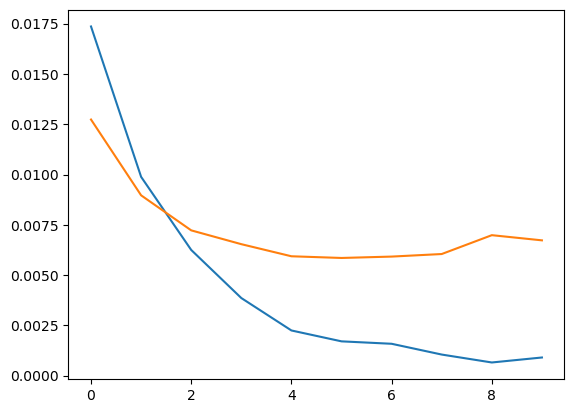

In [9]:
plt.plot(train_loss_list)
plt.plot(valid_loss_list)
plt.show()

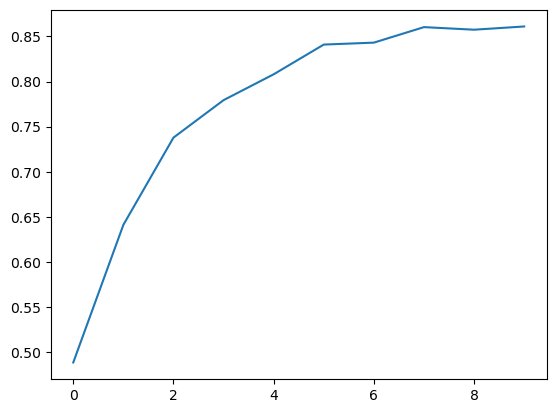

In [10]:
plt.plot(valid_acc_list)
plt.show()

In [12]:
test_loss = 0.
test_acc = 0.
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tqdm(test_loader)):
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = F.cross_entropy(output, target)
        test_loss += loss.item()
        output = F.softmax(output, dim=-1)
        pred = torch.argmax(output, dim=-1)
        correct = torch.sum(pred == target, dtype=torch.float)
        test_acc += correct

test_loss /= len(test_loader.dataset)
test_acc /= len(test_loader.dataset)

# printing loss per epoch
print(f"test loss: {test_loss}, test accuracy: {test_acc}")

100%|██████████| 11/11 [00:01<00:00,  6.19it/s]

test loss: 0.006703101461459709, test accuracy: 0.8610315322875977


## Write Up
After training the model for 20 epochs, I found that it performed slightly better on the both the validation and testing set compared to the base line model. In addition, the model converged in roughly 8 epochs, which is slightly faster than the baseline model. Lastly, I training the transfer model was much faster than the baseline model since training the transfer model only required backprop on the 3 linear layers. Overall, I found transfer learning to perform better than the base line model based on the reasons I listed above. 